In [16]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from scipy.sparse import csr_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [17]:
def dcd_base(X, y, alpha, w, C, tol, it):
    D = 0
    l = len(y)

    for i in range(l):
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)
        w += (alpha[i] - alpha_i_old) * yi * xi

    return w, alpha

def dcd_random_perm(X, y, alpha, w, C, tol, it):
    D = 0
    l = len(y)

    for i in np.random.permutation(l):
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)
        w += (alpha[i] - alpha_i_old) * yi * xi

    return w, alpha

def dcd_online(X, y, alpha, w, C, tol, it):
    D = 0
    l = len(y)

    i = np.random.randint(0, l)
    xi, yi = X[i], y[i]
    G = yi * np.dot(w, xi) - 1

    if alpha[i] == 0 and G >= 0:
        return w, alpha
    elif 0 < alpha[i] < C and abs(G) < tol:
        return w, alpha

    Qii = np.dot(xi, xi) + D
    alpha_i_old = alpha[i]
    alpha[i] -= G / Qii
    alpha[i] = min(max(alpha[i], 0), C)
    w += (alpha[i] - alpha_i_old) * yi * xi

    return w, alpha

def dcd_with_shrinking(X, y, alpha, w, C, tol, it):
    D = 0
    l, n = X.shape

    if it == 0:
        dcd_with_shrinking.active_set = np.ones(l, dtype=bool)
        dcd_with_shrinking.shrink_counter = 0

    active_set = dcd_with_shrinking.active_set

    G_proj = compute_projected_gradient(alpha, X, y, w, D, C)

    bar_G = G_proj[active_set].max()
    under_G = G_proj[active_set].min()

    for i in np.random.permutation(np.where(active_set)[0]):
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1 

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_old_i = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)
        w += (alpha[i] - alpha_old_i) * yi * xi

    for i in range(l):
        if not active_set[i]:
            continue
        if alpha[i] == 0 and G_proj[i] > bar_G:
            active_set[i] = False
        elif alpha[i] == C and G_proj[i] < under_G:
            active_set[i] = False

    dcd_with_shrinking.shrink_counter += 1
    if dcd_with_shrinking.shrink_counter % 10 == 0 or np.sum(active_set) < l * 0.1:
        active_set[:] = True

    return w, alpha

methods_dense = {
    "Base": dcd_base,
    "Random Permutation": dcd_random_perm,
    "Online": dcd_online,
    "With Shrinking": dcd_with_shrinking
}

def compute_projected_gradient(alpha, X, y, w, D, C):
    G_proj = []
    for i in range(len(alpha)):
        G = y[i] * np.dot(w, X[i]) - 1
        if alpha[i] == 0:
            G_proj.append(min(0, G))
        elif alpha[i] == C:  
            G_proj.append(max(0, G))
        else:
            G_proj.append(G)
    return np.array(G_proj)

def dual_objective(alpha, X, y, D):
    w = np.dot((alpha * y), X)
    loss = 0.5 * np.dot(w, w) - np.sum(alpha)
    return loss


def kkt_violations(alpha, X, y, w, D, C, tol=1e-3):
    violations = 0
    for i in range(len(alpha)):
        G = y[i] * np.dot(w, X[i]) - 1
        if alpha[i] == 0 and G < -tol:
            violations += 1
        elif 0 < alpha[i] < C and abs(G) > tol:
            violations += 1
        elif alpha[i] == C and G > tol:
            violations += 1
    return violations / len(alpha)


def primal_gap(w, X, y, C, fP_star):
    fP = primal_objective(w, X, y, C)
    return abs(fP - fP_star) / abs(fP_star)


def primal_objective(w, X, y, C):
    margins = 1 - y * (X @ w)
    hinge_loss = np.sum(np.maximum(0, margins))
    return np.dot(w, w) + C * hinge_loss


def evaluate_with_criteria_dense(X, y, methods, C=1.0, tol=1e-3, max_iter=1000):
    D = 0
    results = []

    for name, method in methods.items():
        for criterion_name in ['delta_alpha', 'projected_gradient', 'dual_objective']:
            alpha = np.zeros(len(y))
            w = np.zeros(X.shape[1])
            alpha_old = alpha.copy()
            f_old = dual_objective(alpha, X, y, D)
            convergence_log = [] 

            start_time = time.time()

            for it in range(max_iter):
                w, alpha = method(X, y, alpha, w, C, tol, it)

                if criterion_name == 'delta_alpha':
                    delta = np.linalg.norm(alpha - alpha_old)
                    convergence_log.append(delta)
                    if delta < tol:
                        break
                elif criterion_name == 'projected_gradient':
                    G_proj = compute_projected_gradient(alpha, X, y, w, D, C)
                    gap = G_proj.max() - G_proj.min()
                    convergence_log.append(gap)
                    if gap < tol:
                        break
                elif criterion_name == 'dual_objective':
                    f_new = dual_objective(alpha, X, y, D)
                    diff = abs(f_new - f_old)
                    convergence_log.append(diff)
                    if diff < tol:
                        break
                    f_old = f_new

                alpha_old = alpha.copy()

            elapsed = time.time() - start_time
            accuracy = accuracy_score(y, np.sign(X @ w))

            kkt_error = kkt_violations(alpha, X, y, w, D, tol)
            fP = primal_objective(w, X, y, C)
            
            results.append({
                'Method': name,
                'Criterion': criterion_name,
                'Time': elapsed,
                'Accuracy': accuracy,
                'Iterations': it + 1,
                'Log': convergence_log,
                'KKT_violation': kkt_error,
                'fP': fP 
            })

    fP_star = min(res['fP'] for res in results)
    for res in results:
        res['PrimalGap'] = abs(res['fP'] - fP_star) / abs(fP_star)

    return results
def display_results_table(results):
    df = pd.DataFrame(results)
    display(df)

def plot_convergence(results):
    plt.figure(figsize=(12, 6))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    extended_colors = plt.get_cmap('tab20').colors  

    for idx, res in enumerate(results):
        label = f"{res['Method']} - {res['Criterion']}"
        iters = list(range(1, len(res['Log']) + 1))
        color = extended_colors[idx % len(extended_colors)]  
        plt.plot(iters, res['Log'], label=label, color=color, linewidth=2)

    plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Stopping criterion (log)")
    plt.title("Convergence of stopping criteria")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
def compute_projected_gradient_s(alpha, X, y, w, D, C):
    G = y * X.dot(w) - 1

    G_proj = G.copy()

    mask_lower = (alpha == 0)
    mask_upper = (alpha == C)
    mask_middle = (alpha > 0) & (alpha < C)

    G_proj[mask_lower] = np.minimum(0, G[mask_lower])
    G_proj[mask_upper] = np.maximum(0, G[mask_upper])
    G_proj[~(mask_lower | mask_upper | mask_middle)] = 0  

    return G_proj

def dual_objective_s(alpha, X, y, D):
    w = X.T.dot(alpha * y)  

    w_norm_sq = np.dot(w, w)

    loss = w_norm_sq - np.sum(alpha)

    return loss


def dcd_base_s(X, y, alpha, w, C, tol, it):
    D = 0
    l = X.shape[0]

    for i in range(l):
        xi = X.getrow(i)         
        yi = y[i]
        G = yi * xi.dot(w).item() - 1  

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = xi.multiply(xi).sum() + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)

        delta_alpha = alpha[i] - alpha_i_old
        if delta_alpha != 0:
            w[xi.indices] += delta_alpha * yi * xi.data

    return w, alpha

def dcd_random_perm_s(X, y, alpha, w, C, tol, it):
    D = 0
    l = X.shape[0]

    for i in np.random.permutation(l):
        xi = X.getrow(i)  
        yi = y[i]
        G = yi * xi.dot(w).item() - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = xi.multiply(xi).sum() + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)

        delta_alpha = alpha[i] - alpha_i_old
        if delta_alpha != 0:
            w[xi.indices] += delta_alpha * yi * xi.data

    return w, alpha

def dcd_online_s(X, y, alpha, w, C, tol, it):
    D = 0
    l = X.shape[0]

    i = np.random.randint(0, l)
    xi = X.getrow(i)  
    yi = y[i]

    G = yi * xi.dot(w).item() - 1

    if alpha[i] == 0 and G >= 0:
        return w, alpha
    elif 0 < alpha[i] < C and abs(G) < tol:
        return w, alpha

    Qii = xi.multiply(xi).sum() + D
    alpha_i_old = alpha[i]
    alpha[i] -= G / Qii
    alpha[i] = min(max(alpha[i], 0), C)

    delta_alpha = alpha[i] - alpha_i_old
    if delta_alpha != 0:
        w[xi.indices] += delta_alpha * yi * xi.data

    return w, alpha

def dcd_with_shrinking_s(X, y, alpha, w, C, tol, it):
    D = 0
    l = X.shape[0]

    if it == 0:
        dcd_with_shrinking_s.active_set = np.ones(l, dtype=bool)
        dcd_with_shrinking_s.shrink_counter = 0

    active_set = dcd_with_shrinking_s.active_set

    G_proj = compute_projected_gradient_s(alpha, X, y, w, D, C)

    bar_G = G_proj[active_set].max()
    under_G = G_proj[active_set].min()

    for i in np.random.permutation(np.where(active_set)[0]):
        xi = X.getrow(i)
        yi = y[i]
        G = yi * xi.dot(w).item() - 1

        if alpha[i] == 0 and G >= 0:
            continue
        elif 0 < alpha[i] < C and abs(G) < tol:
            continue

        Qii = xi.multiply(xi).sum() + D
        alpha_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = min(max(alpha[i], 0), C)

        delta_alpha = alpha[i] - alpha_old
        if delta_alpha != 0:
            w[xi.indices] += delta_alpha * yi * xi.data

    for i in range(l):
        if not active_set[i]:
            continue
        if alpha[i] == 0 and G_proj[i] > bar_G:
            active_set[i] = False
        elif alpha[i] == C and G_proj[i] < under_G:
            active_set[i] = False

    dcd_with_shrinking_s.shrink_counter += 1
    if dcd_with_shrinking_s.shrink_counter % 10 == 0 or np.sum(active_set) < l * 0.1:
        active_set[:] = True

    return w, alpha


def kkt_violations_s(alpha, X, y, w, D, C, tol=1e-3):
    violations = 0
    l = len(alpha)

    for i in range(l):
        xi = X.getrow(i)
        G = y[i] * xi.dot(w).item() - 1  

        if alpha[i] == 0 and G < -tol:
            violations += 1
        elif 0 < alpha[i] < C and abs(G) > tol:
            violations += 1
        elif alpha[i] == C and G > tol:
            violations += 1

    return violations / l

def primal_objective_s(w, X, y, C):
    margins = 1 - y * X.dot(w)
    hinge_loss = np.sum(np.maximum(0, margins))
    return np.dot(w, w) + C * hinge_loss

def primal_gap_s(w, X, y, C, fP_star):
    fP = primal_objective_s(w, X, y, C)
    return abs(fP - fP_star) / abs(fP_star)

def evaluate_with_criteria_sparse(X, y, methods, C=1.0, tol=1e-3, max_iter=1000):
    D = 0
    results = []

    for name, method in methods.items():
        for criterion_name in ['delta_alpha', 'projected_gradient', 'dual_objective']:
            alpha = np.zeros(len(y))
            w = np.zeros(X.shape[1])
            alpha_old = alpha.copy()
            f_old = dual_objective_s(alpha, X, y, D)
            convergence_log = [] 

            start_time = time.time()

            for it in range(max_iter):
                w, alpha = method(X, y, alpha, w, C, tol, it)

                if criterion_name == 'delta_alpha':
                    delta = np.linalg.norm(alpha - alpha_old)
                    convergence_log.append(delta)
                    if delta < tol:
                        break
                elif criterion_name == 'projected_gradient':
                    G_proj = compute_projected_gradient_s(alpha, X, y, w, D, C)
                    gap = G_proj.max() - G_proj.min()
                    convergence_log.append(gap)
                    if gap < tol:
                        break
                elif criterion_name == 'dual_objective':
                    f_new = dual_objective_s(alpha, X, y, D)
                    diff = abs(f_new - f_old)
                    convergence_log.append(diff)
                    if diff < tol:
                        break
                    f_old = f_new

                alpha_old = alpha.copy()

            elapsed = time.time() - start_time
            accuracy = accuracy_score(y, np.sign(X @ w))

            kkt_error = kkt_violations_s(alpha, X, y, w, D, C, tol)
            fP = primal_objective_s(w, X, y, C)

            results.append({
                'Method': name,
                'Criterion': criterion_name,
                'Time': elapsed,
                'Accuracy': accuracy,
                'Iterations': it + 1,
                'Log': convergence_log,
                'KKT_violation': kkt_error,
                'fP': fP
            })

    fP_star = min(res['fP'] for res in results)
    for res in results:
        res['PrimalGap'] = abs(res['fP'] - fP_star) / abs(fP_star)

    return results

def display_results_table(results):
    df = pd.DataFrame(results)
    display(df)

methods_sparse = {
    "Base": dcd_base_s,
    "Random Permutation": dcd_random_perm_s,
    "Online": dcd_online_s,
    "With Shrinking": dcd_with_shrinking_s
}

In [19]:
def generate_synthetic_dataset(n_samples, n_features, type):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=50,
        n_redundant=0,
        n_classes=2,
        random_state=42
    )

    density = None

    if type == 'sparse':
        X[np.abs(X) < 5.0] = 0
        X = csr_matrix(X)
        density = 100 * X.nnz / (X.shape[0] * X.shape[1])

    y = 2 * y - 1
    return X, y, density

In [20]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=100000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.053982,1.000,1,[0.00030044059243505405],0.989,17.894143,112.409930
1,Base,projected_gradient,26.062827,1.000,1000,"[0.8194906439879301, 0.07748941139591259, 0.00...",0.000,0.157783,0.000000
2,Base,dual_objective,0.125126,1.000,2,"[0.004550752615380058, 4.715106061390674e-05]",0.736,3.214872,19.375293
3,Random Permutation,delta_alpha,0.051546,1.000,1,[0.00030037405141968574],0.986,18.726442,117.684895
4,Random Permutation,projected_gradient,26.790519,1.000,1000,"[0.8144148761985218, 0.07931100387697754, 0.01...",0.000,0.183618,0.163736
5,Random Permutation,dual_objective,0.121537,1.000,2,"[0.0045495535044865806, 4.782771404185631e-05]",0.907,8.480937,52.750690
6,Online,delta_alpha,0.000091,0.491,1,[9.916824290035413e-06],0.999,999.059883,6330.865882
7,Online,projected_gradient,13.279287,0.885,1000,"[1.0109805390518605, 1.016806487863833, 1.0194...",0.982,357.889557,2267.241085
8,Online,dual_objective,0.011092,0.490,1,[4.968229155567491e-06],0.999,999.030867,6330.681986
9,With Shrinking,delta_alpha,0.062939,1.000,1,[0.0003004229544098996],0.987,17.950257,112.765570


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.096622,1.000,2,"[0.0029241016777386284, 0.0007411741793399838]",0.951,15.446444,67.196579
1,Base,projected_gradient,13.190024,1.000,1000,"[2.301310469746217, 0.6582113364703284, 0.3252...",0.000,0.227700,0.005305
2,Base,dual_objective,0.190654,1.000,4,"[0.004915472515509375, 0.0024018007154558707, ...",0.887,9.528262,41.067603
3,Random Permutation,delta_alpha,0.094570,1.000,2,"[0.0029269987277096136, 0.0007519845410859611]",0.951,46.637049,204.904168
4,Random Permutation,projected_gradient,13.277665,1.000,1000,"[2.0907834877677605, 0.7750226103297596, 0.240...",0.000,0.226499,0.000000
5,Random Permutation,dual_objective,0.188236,1.000,4,"[0.005798700595438841, 0.007041344011514281, 0...",0.805,4.419021,18.510129
6,Online,delta_alpha,0.000088,0.480,1,[0.00011807165763298536],0.999,999.347453,4411.153219
7,Online,projected_gradient,0.852235,0.930,1000,"[1.0513110956099152, 1.1175316121012868, 1.105...",0.975,284.771349,1256.275258
8,Online,dual_objective,0.000916,0.472,1,[4.0657581468206416e-20],0.999,999.638586,4412.438582
9,With Shrinking,delta_alpha,0.095684,1.000,2,"[0.002907687925263358, 0.0007968676164496973]",0.955,48.432931,212.833049


In [21]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=500000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.365251,1.000,1,[6.267553212428712e-05],0.959,9.907258,69.060663
1,Base,projected_gradient,121.380108,1.000,1000,"[0.26997407500687165, 0.008516292984702356, 0....",0.000,0.145695,0.030305
2,Base,dual_objective,0.406877,1.000,1,[0.0009837035985597016],0.959,9.907258,69.060663
3,Random Permutation,delta_alpha,0.353995,1.000,1,[6.267514805996094e-05],0.970,10.156356,70.822190
4,Random Permutation,projected_gradient,120.934790,1.000,1000,"[0.3258948384729812, 0.009474707308250951, 0.0...",0.000,0.154701,0.093988
5,Random Permutation,dual_objective,0.421420,1.000,1,[0.0009836389127202009],0.969,10.112363,70.511090
6,Online,delta_alpha,0.000535,0.504,1,[2.002218782177775e-06],0.999,998.978862,7063.428726
7,Online,projected_gradient,60.779846,0.852,1000,"[1.0048757654193965, 1.0061883638823372, 1.007...",0.957,356.749032,2521.804245
8,Online,dual_objective,0.055930,0.496,1,[9.973316864900722e-07],0.999,998.980036,7063.437034
9,With Shrinking,delta_alpha,0.413570,1.000,1,[6.267266945834202e-05],0.968,10.409471,72.612135


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.258654,1.000,1,[0.0006802448444021512],0.986,15.704159,104.860380
1,Base,projected_gradient,26.418753,1.000,1000,"[0.9544863147602484, 0.1544274309705802, 0.012...",0.000,0.148348,0.000000
2,Base,dual_objective,0.758735,1.000,3,"[0.0013785387449763015, 0.0014392128552936367,...",0.454,0.922653,5.219527
3,Random Permutation,delta_alpha,0.257250,1.000,1,[0.0006794127576780469],0.990,17.678753,118.170950
4,Random Permutation,projected_gradient,27.988299,1.000,1000,"[1.1164213180685072, 0.23946429866734642, 0.04...",0.000,0.161516,0.088768
5,Random Permutation,dual_objective,0.761149,1.000,3,"[0.0013977357813383141, 0.0016160294707818594,...",0.726,0.747082,4.036012
6,Online,delta_alpha,0.000525,0.536,1,[2.3283235806819465e-05],0.999,998.732127,6731.367189
7,Online,projected_gradient,4.590632,0.915,1000,"[1.0096896140455374, 1.0268077753416776, 1.037...",0.982,326.046703,2196.852723
8,Online,dual_objective,0.004885,0.467,1,[0.0],0.999,999.110039,6733.914661
9,With Shrinking,delta_alpha,0.262575,1.000,1,[0.0006797086610754991],0.985,17.312493,115.702022


In [22]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=100000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense, C=0.001)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse, C=0.001)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.051100,1.000,1,[0.00030044059243505405],0.989,0.027671,1.961180
1,Base,projected_gradient,27.414664,1.000,1000,"[0.8194906439879301, 0.07748941139591259, 0.00...",0.000,0.009345,0.000000
2,Base,dual_objective,0.121704,1.000,2,"[0.004550752615380058, 4.715106061390674e-05]",0.736,0.012375,0.324283
3,Random Permutation,delta_alpha,0.049845,1.000,1,[0.00030053315908896126],0.989,0.027102,1.900273
4,Random Permutation,projected_gradient,28.503679,1.000,1000,"[0.7443809325158828, 0.08400715376919543, 0.01...",0.000,0.009373,0.003008
5,Random Permutation,dual_objective,0.120780,1.000,2,"[0.004550526481592895, 4.6875172171948615e-05]",0.889,0.017227,0.843445
6,Online,delta_alpha,0.000091,0.527,1,[9.912251401832372e-06],0.999,0.998850,105.888890
7,Online,projected_gradient,13.874579,0.889,1000,"[1.010291190374033, 1.020023898269925, 1.02598...",0.983,0.359972,37.521320
8,Online,dual_objective,0.011055,0.496,1,[4.981320320535046e-06],0.999,0.999073,105.912697
9,With Shrinking,delta_alpha,0.063122,1.000,1,[0.0003002730892967621],0.985,0.029030,2.106549


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.101922,1.000,2,"[0.0029241016777386284, 0.0007411741793399838]",0.951,0.103217,0.234289
1,Base,projected_gradient,13.449799,1.000,1000,"[2.301310469746217, 0.6582113364703284, 0.3252...",0.000,0.083625,0.000000
2,Base,dual_objective,0.193290,1.000,4,"[0.004915472515509375, 0.0024018007154558707, ...",0.887,0.092886,0.110743
3,Random Permutation,delta_alpha,0.097103,1.000,2,"[0.0029224902021938366, 0.0007605250940627068]",0.950,0.126030,0.507090
4,Random Permutation,projected_gradient,13.458564,1.000,1000,"[2.1503114726804267, 0.7386870013245174, 0.304...",0.000,0.083645,0.000247
5,Random Permutation,dual_objective,0.194675,1.000,4,"[0.0053960962413443225, 0.0066383490976542475,...",0.781,0.086577,0.035303
6,Online,delta_alpha,0.000098,0.595,1,[0.00011010604477372645],0.999,0.996099,10.911544
7,Online,projected_gradient,0.859888,0.903,1000,"[1.0424311509383308, 1.0909281287927521, 1.075...",0.967,0.356884,3.267690
8,Online,dual_objective,0.000962,0.441,1,[4.0657581468206416e-20],0.999,1.000878,10.968690
9,With Shrinking,delta_alpha,0.098284,1.000,2,"[0.0029325183107149506, 0.0007251314481852626]",0.952,0.125244,0.497696


In [23]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=100000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense, C=100)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse, C=100)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.050856,1.000,1,[0.00030044059243505405],0.989,1788.445334,119.289316
1,Base,projected_gradient,26.412400,1.000,1000,"[0.8194906439879301, 0.07748941139591259, 0.00...",0.000,14.867865,0.000000
2,Base,dual_objective,0.121026,1.000,2,"[0.004550752615380058, 4.715106061390674e-05]",0.736,320.579425,20.561900
3,Random Permutation,delta_alpha,0.049764,1.000,1,[0.0003004763634677569],0.985,1768.842518,117.970847
4,Random Permutation,projected_gradient,27.056752,1.000,1000,"[0.7922055007590554, 0.07917094551798587, 0.01...",0.000,17.083727,0.149037
5,Random Permutation,dual_objective,0.121589,1.000,2,"[0.004547766481080889, 4.959574359342939e-05]",0.906,835.282912,55.180420
6,Online,delta_alpha,0.000089,0.503,1,[9.830756465497143e-06],0.999,99912.137453,6719.005607
7,Online,projected_gradient,13.625415,0.902,1000,"[1.0117223751195357, 1.0146749009956293, 1.021...",0.978,33684.002062,2264.557404
8,Online,dual_objective,0.011261,0.497,1,[4.92158569547925e-06],0.999,99898.190429,6718.067542
9,With Shrinking,delta_alpha,0.063107,1.000,1,[0.00030051628405282333],0.985,1703.005902,113.542732


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.095682,1.000,2,"[0.0029241016777386284, 0.0007411741793399838]",0.951,1535.946413,105.778085
1,Base,projected_gradient,13.236456,1.000,1000,"[2.301310469746217, 0.6582113364703284, 0.3252...",0.000,14.505472,0.008412
2,Base,dual_objective,0.190808,1.000,4,"[0.004915472515509375, 0.0024018007154558707, ...",0.887,944.565573,64.665639
3,Random Permutation,delta_alpha,0.094262,1.000,2,"[0.0029221402711609346, 0.0007587929364830399]",0.948,5166.980314,358.205410
4,Random Permutation,projected_gradient,13.305884,1.000,1000,"[2.682256427684182, 0.6798858040984309, 0.2603...",0.000,14.384472,0.000000
5,Random Permutation,dual_objective,0.191227,1.000,4,"[0.005625453970263192, 0.007083990108845931, 0...",0.799,411.272584,27.591426
6,Online,delta_alpha,0.000092,0.455,1,[0.00011465474415035885],0.999,100033.563322,6953.274052
7,Online,projected_gradient,0.857087,0.909,1000,"[1.054927857458553, 1.059782884406498, 1.05821...",0.969,30920.714536,2148.589754
8,Online,dual_objective,0.000925,0.572,1,[0.0],0.999,99652.032755,6926.750273
9,With Shrinking,delta_alpha,0.097107,1.000,2,"[0.0029166546280525885, 0.0007899161246349996]",0.952,4766.845725,330.388290


In [24]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=100000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense, tol=1e-4)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse, tol=1e-4)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.100212,1.000,2,"[0.00030044059243505405, 3.057083985439539e-05]",0.736,3.214809,154.586523
1,Base,projected_gradient,26.368709,1.000,1000,"[0.8194906439879301, 0.07748823133753646, 0.00...",0.000,0.022196,0.074236
2,Base,dual_objective,0.120986,1.000,2,"[0.004550752615380058, 4.715101789829618e-05]",0.736,3.214809,154.586523
3,Random Permutation,delta_alpha,0.099422,1.000,2,"[0.0003003026973559977, 3.180855378716163e-05]",0.894,8.184143,395.086475
4,Random Permutation,projected_gradient,27.151465,1.000,1000,"[0.9217627178147901, 0.10379243388756154, 0.01...",0.000,0.020663,0.000000
5,Random Permutation,dual_objective,0.121686,1.000,2,"[0.004552200685729472, 4.531808322751161e-05]",0.891,7.384152,356.369473
6,Online,delta_alpha,0.000089,0.534,1,[9.97106353883158e-06],0.999,998.585292,48327.349331
7,Online,projected_gradient,13.654340,0.902,1000,"[1.0106723496870471, 1.0202890218524967, 1.022...",0.975,332.364963,16084.406204
8,Online,dual_objective,0.011156,0.491,1,[4.972233284522623e-06],0.999,998.982481,48346.571984
9,With Shrinking,delta_alpha,0.126367,1.000,2,"[0.00030034504572053265, 3.1396421428291795e-05]",0.892,7.935479,383.051900


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.237440,1.000,5,"[0.0029241016777386284, 0.0007411742925140736,...",0.944,6.329964,63.218806
1,Base,projected_gradient,13.336327,1.000,1000,"[2.301310469746217, 0.6582073077518534, 0.3252...",0.000,0.100025,0.014778
2,Base,dual_objective,0.283915,1.000,6,"[0.004915472515509375, 0.0024020068385369603, ...",0.931,2.754993,26.949980
3,Random Permutation,delta_alpha,0.190628,1.000,4,"[0.0029191127234474445, 0.0007681666510837361,...",0.935,4.355762,43.190109
4,Random Permutation,projected_gradient,13.256286,1.000,1000,"[2.8755076897021397, 0.6562294386342716, 0.224...",0.000,0.098569,0.000000
5,Random Permutation,dual_objective,0.304822,1.000,6,"[0.00569753587957135, 0.006951209371150471, 0....",0.799,0.478079,3.850207
6,Online,delta_alpha,0.000179,0.639,2,"[0.00011065189509259498, 9.960761638692441e-05]",0.999,991.253401,10055.472514
7,Online,projected_gradient,0.879604,0.908,1000,"[1.0450054631953865, 1.0512202463903995, 1.084...",0.979,285.457003,2895.020841
8,Online,dual_objective,0.000928,0.493,1,[9.486769009248164e-20],0.999,998.694937,10130.968449
9,With Shrinking,delta_alpha,0.194065,1.000,4,"[0.002947578391729193, 0.0006865177085151216, ...",0.931,2.733356,26.730470


In [25]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=100000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense, tol=1e-6)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse, tol=1e-6)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.199540,1.000,4,"[0.00030044059243505405, 3.057083985439539e-05...",0.000,0.015550,0.669198
1,Base,projected_gradient,27.411045,1.000,1000,"[0.8194906439879301, 0.07748823133753646, 0.00...",0.000,0.009332,0.001723
2,Base,dual_objective,0.207218,1.000,3,"[0.004550752615380058, 4.715101789829618e-05, ...",0.000,0.148739,14.965958
3,Random Permutation,delta_alpha,0.200233,1.000,4,"[0.0003004186231070428, 3.0720680125729983e-05...",0.000,0.136056,13.604590
4,Random Permutation,projected_gradient,28.500018,1.000,1000,"[0.8488659067299905, 0.09207636826581456, 0.01...",0.000,0.009320,0.000388
5,Random Permutation,dual_objective,0.193294,1.000,3,"[0.004550847195176847, 4.6615069693114845e-05,...",0.000,0.261639,27.084959
6,Online,delta_alpha,0.000410,0.547,7,"[9.898306058742283e-06, 9.911633604497804e-06,...",0.994,993.028853,106592.940841
7,Online,projected_gradient,13.951410,0.892,1000,"[1.0110203127759605, 1.0175095333454722, 1.019...",0.367,355.509224,38160.156190
8,Online,dual_objective,0.392782,0.618,35,"[4.95182120094972e-06, 4.9376785280301664e-06,...",0.966,960.994105,103154.259260
9,With Shrinking,delta_alpha,0.254815,1.000,4,"[0.00030039142614274707, 3.099048707724064e-05...",0.000,0.129150,12.863206


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.617438,1.000,13,"[0.0029241016777386284, 0.0007411742925140736,...",0.944,0.139677,0.670375
1,Base,projected_gradient,13.825164,1.000,1000,"[2.301310469746217, 0.6582073077518534, 0.3252...",0.000,0.083620,0.000000
2,Base,dual_objective,0.434163,1.000,9,"[0.004915472515509375, 0.0024020068385369603, ...",0.954,0.475408,4.685345
3,Random Permutation,delta_alpha,0.377577,1.000,8,"[0.0029083714185741505, 0.000799645209822299, ...",0.934,0.109778,0.312820
4,Random Permutation,projected_gradient,13.567502,1.000,1000,"[2.330494541706422, 0.5389989104181897, 0.1566...",0.000,0.083637,0.000204
5,Random Permutation,dual_objective,0.435199,1.000,9,"[0.005378574484587756, 0.0063584672003518805, ...",0.896,0.089814,0.074073
6,Online,delta_alpha,0.012051,0.773,204,"[0.00010805181964803427, 0.0001089948821688497...",0.999,696.848819,8332.532502
7,Online,projected_gradient,0.860452,0.917,1000,"[1.042013123193451, 1.0717220424419573, 1.0772...",0.972,292.102252,3492.216237
8,Online,dual_objective,0.000921,0.578,1,[2.710505431213761e-20],0.999,996.127277,11911.568139
9,With Shrinking,delta_alpha,0.386160,1.000,8,"[0.0029181029247493714, 0.0007699876137955048,...",0.941,0.129155,0.544554


In [26]:
X_dense, y_dense, _ = generate_synthetic_dataset(n_samples=1000, n_features=100000, type='dense')

X_sparse_raw = X_dense.copy()
threshold = np.percentile(np.abs(X_sparse_raw), 99)
X_sparse_raw[np.abs(X_sparse_raw) < threshold] = 0
X_sparse = csr_matrix(X_sparse_raw)
density = 100 * X_sparse.nnz / (X_sparse.shape[0] * X_sparse.shape[1])
y_sparse = y_dense
results_dense = evaluate_with_criteria_dense(X_dense, y_dense, methods_dense, tol=1e-8)
results_sparse = evaluate_with_criteria_sparse(X_sparse, y_sparse, methods_sparse, tol=1e-8)

display_results_table(results_dense)
display_results_table(results_sparse)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.249819,1.000,5,"[0.00030044059243505405, 3.057083985439539e-05...",0.00,0.009775,0.062813
1,Base,projected_gradient,27.280196,1.000,1000,"[0.8194906439879301, 0.07748823133753646, 0.00...",0.00,0.009198,0.000011
2,Base,dual_objective,0.245456,1.000,4,"[0.004550752615380058, 4.715101789829618e-05, ...",0.00,0.015550,0.690664
3,Random Permutation,delta_alpha,0.299455,1.000,6,"[0.00030046217469007977, 3.0251442229451306e-0...",0.00,0.011483,0.248452
4,Random Permutation,projected_gradient,28.648678,1.000,1000,"[0.7925928091238448, 0.09729646692720739, 0.01...",0.00,0.009198,0.000000
5,Random Permutation,dual_objective,0.306081,1.000,5,"[0.004546582283829299, 5.082728873084634e-05, ...",0.00,0.014330,0.557972
6,Online,delta_alpha,0.002746,0.609,51,"[9.915867921566247e-06, 9.882707678330923e-06,...",0.95,944.366555,102673.012993
7,Online,projected_gradient,13.960809,0.892,1000,"[1.012166379226223, 1.0161298550600624, 1.0217...",0.35,337.747650,36719.811916
8,Online,dual_objective,0.461391,0.586,41,"[4.941569191801399e-06, 4.897012035035375e-06,...",0.96,955.933764,103930.630329
9,With Shrinking,delta_alpha,0.382829,1.000,6,"[0.0003004781283660882, 3.0091246323500704e-05...",0.00,0.011271,0.225429


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,1.039183,1.000,22,"[0.0029241016777386284, 0.0007411742925140736,...",0.936,0.084259,9.358962e-03
1,Base,projected_gradient,14.195470,1.000,1000,"[2.301310469746217, 0.6582073077518534, 0.3252...",0.000,0.083478,7.239641e-07
2,Base,dual_objective,0.963612,1.000,20,"[0.004915472515509375, 0.0024020068385369603, ...",0.950,0.085222,2.089460e-02
3,Random Permutation,delta_alpha,0.574338,1.000,12,"[0.0029304698140052063, 0.0007388215852835002,...",0.912,0.083646,2.013534e-03
4,Random Permutation,projected_gradient,13.907929,1.000,1000,"[2.226097359151083, 0.599771069839084, 0.21170...",0.000,0.083478,1.330187e-06
5,Random Permutation,dual_objective,0.582454,1.000,12,"[0.00544751078377273, 0.006781239103154785, 0....",0.914,0.083621,1.716821e-03
6,Online,delta_alpha,0.018881,0.811,323,"[0.00011187093074129424, 0.0001087529206300466...",0.997,584.445649,7.000240e+03
7,Online,projected_gradient,0.862005,0.908,1000,"[1.0577619386450654, 1.0650748262366008, 1.079...",0.976,287.449593,3.442440e+03
8,Online,dual_objective,0.000922,0.557,1,[6.776263578034403e-20],0.999,996.779803,1.193971e+04
9,With Shrinking,delta_alpha,0.583780,1.000,12,"[0.0029160503785303025, 0.0007817653456301032,...",0.936,0.083751,3.276650e-03


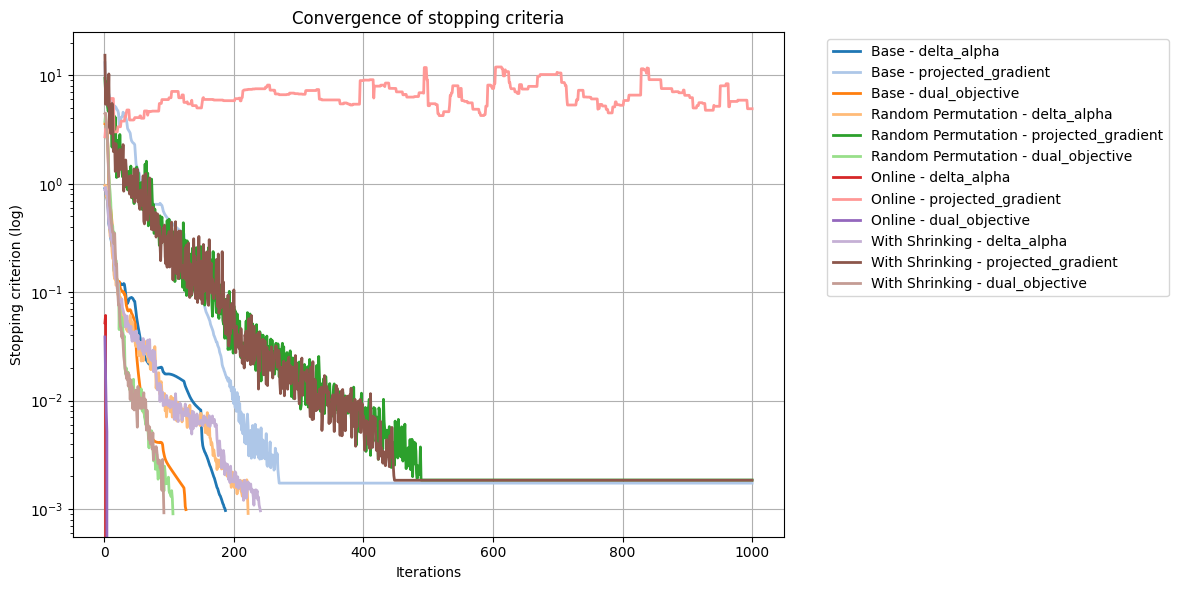

569
30


,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,0.055497,0.987698,187,"[0.9026038510533022, 0.8659030964198494, 0.761...",0.000000,31.331133,0.001117
1,Base,projected_gradient,0.544269,0.987698,1000,"[13.062650773830535, 6.479482733746333, 7.8246...",0.000000,31.309291,0.000419
2,Base,dual_objective,0.038476,0.987698,126,"[3.584430194826857, 3.822802112261046, 3.26872...",0.000000,31.525680,0.007333
3,Random Permutation,delta_alpha,0.075403,0.987698,222,"[0.9621389603896011, 0.95157150641522, 0.77186...",0.000000,31.299652,0.000111
4,Random Permutation,projected_gradient,0.586031,0.987698,1000,"[9.384548792740668, 6.928132708031347, 6.55606...",0.000000,31.296685,0.000016
5,Random Permutation,dual_objective,0.037442,0.987698,106,"[3.7711423196917018, 4.335931233929172, 3.6392...",0.000000,31.576495,0.008957
6,Online,delta_alpha,0.000027,0.724077,3,"[0.052135439995139234, 0.0609698849633902, 0.0]",0.790861,395.458019,11.635982
7,Online,projected_gradient,0.268063,0.968366,1000,"[2.709237045150717, 3.209317541988017, 3.08850...",0.049209,53.550807,0.711097
8,Online,dual_objective,0.000044,0.912127,5,"[0.03860993223746813, 0.016479045401345885, 0....",0.604569,202.616801,5.474169
9,With Shrinking,delta_alpha,0.162936,0.987698,241,"[0.8781247752767829, 0.9265354251954926, 0.802...",0.000000,31.301777,0.000179


In [27]:
data = load_breast_cancer()
X = data.data
y = data.target
y = 2 * (y - 0.5)  
X = StandardScaler().fit_transform(X)

results = evaluate_with_criteria_dense(X, y, methods_dense, max_iter=1000)

plot_convergence(results)
print(len(X))
print(len(X[0]))
display_results_table(results)

,Method,Criterion,Time,Accuracy,Iterations,Log,KKT_violation,fP,PrimalGap
0,Base,delta_alpha,1.242879,0.995333,50,"[15.559660176534662, 6.600056099366039, 2.6040...",0.000000,313.984570,0.000059
1,Base,projected_gradient,12.579738,0.995333,1000,"[2.737588387362452, 0.8615297709355553, 0.6070...",0.000000,313.984570,0.000059
2,Base,dual_objective,1.173939,0.995333,41,"[53.64154226611453, 58.84233652197997, 12.8114...",0.088681,314.044302,0.000249
3,Random Permutation,delta_alpha,0.784111,0.995333,42,"[15.577646492814024, 6.603499297413206, 2.7206...",0.000000,313.975107,0.000028
4,Random Permutation,projected_gradient,13.492457,0.995333,1000,"[2.2173047474825287, 0.9271103287624695, 0.608...",0.000000,313.982548,0.000052
5,Random Permutation,dual_objective,0.377878,0.995333,13,"[60.10044396670594, 95.62106109305745, 13.6691...",0.098016,314.052354,0.000274
6,Online,delta_alpha,0.003867,0.848308,89,"[1.0, 1.0, 1.0, 0.9989337112942597, 0.97398002...",0.933489,595.063671,0.895311
7,Online,projected_gradient,0.119746,0.978996,1000,"[1.1941684783249968, 1.137374658078117, 1.1413...",0.729288,376.274751,0.198456
8,Online,dual_objective,0.000145,0.560093,1,[7.771561172376096e-16],0.998833,852.223407,1.714380
9,With Shrinking,delta_alpha,0.855303,0.995333,49,"[15.48250724663939, 6.6931368187687825, 2.5726...",0.000000,313.994537,0.000090


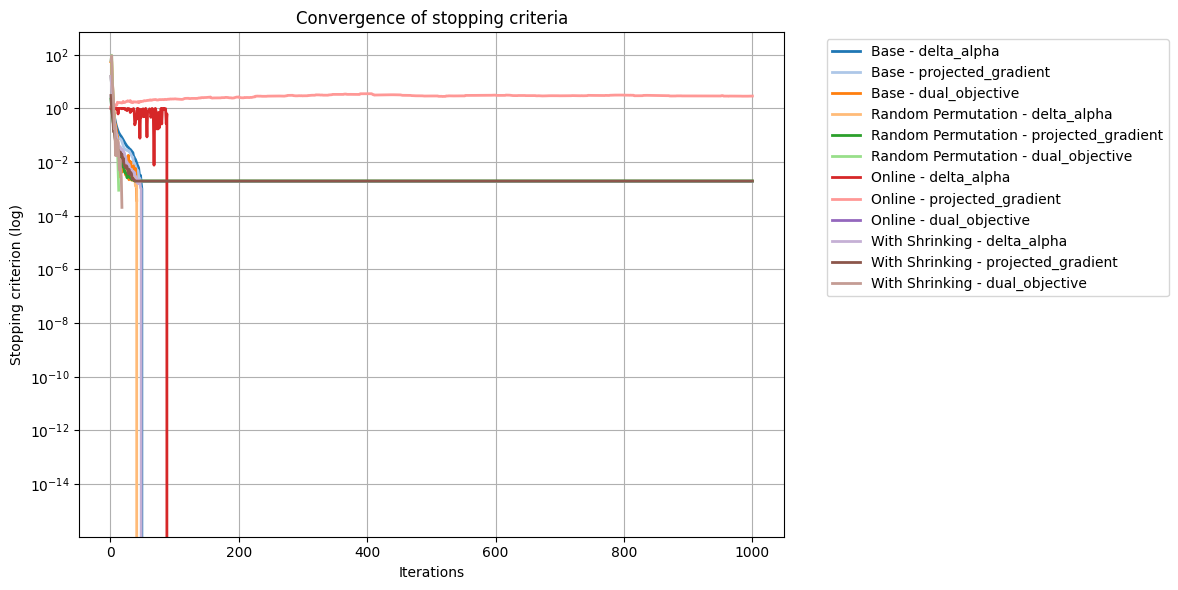

In [28]:
categories = ['alt.atheism', 'talk.religion.misc']
data = fetch_20newsgroups(subset='train', categories=categories)

vectorizer = TfidfVectorizer(
    max_features=100000,
    stop_words='english',
    min_df=1
)
X = vectorizer.fit_transform(data.data)  

y = data.target
y = 2 * y - 1  

X = X[:1000]
y = y[:1000]

d = X.nnz / (X.shape[0] * X.shape[1])

results = evaluate_with_criteria_sparse(X, y, methods_sparse, max_iter=1000)

display_results_table(results)
plot_convergence(results)

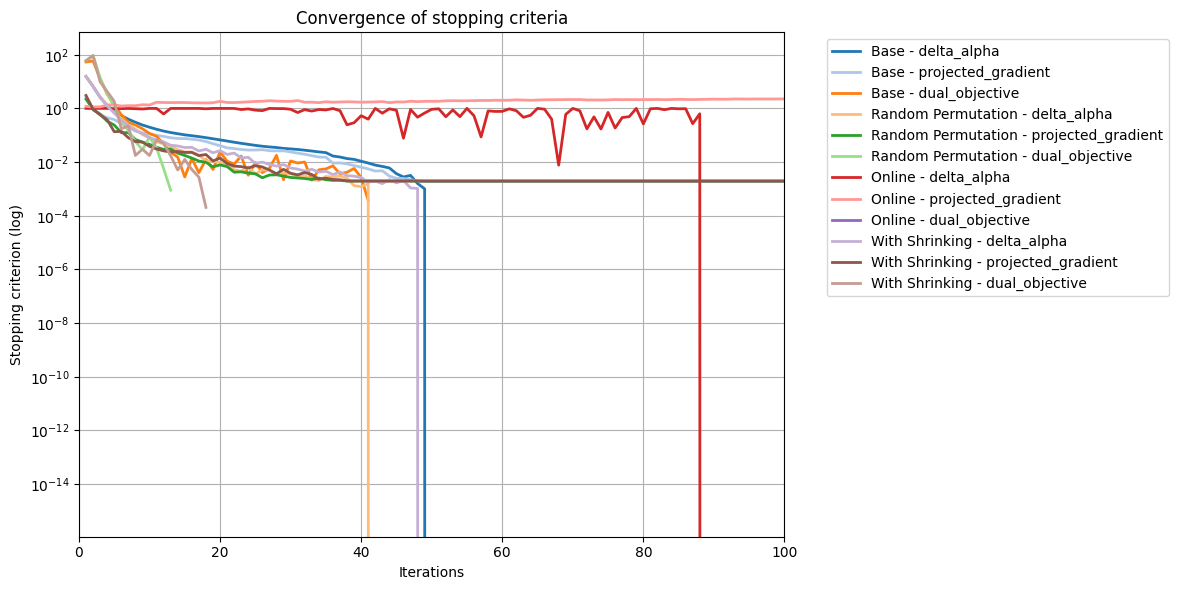

In [29]:
def plot_convergence(results):
    plt.figure(figsize=(12, 6))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    extended_colors = plt.get_cmap('tab20').colors  

    for idx, res in enumerate(results):
        label = f"{res['Method']} - {res['Criterion']}"
        iters = list(range(1, len(res['Log']) + 1))
        color = extended_colors[idx % len(extended_colors)]  
        plt.plot(iters, res['Log'], label=label, color=color, linewidth=2)

    plt.yscale('log')
    plt.xlabel("Iterations")
    plt.xlim(0, 100)
    plt.ylabel("Stopping criterion (log)")
    plt.title("Convergence of stopping criteria")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_convergence(results)